In [1]:
from matplotlib import pyplot as plt
from scipy.stats import entropy
import numpy as np
import torch
import sys
import glob
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss, Disco
from utils import Metrics, DataSet
torch.manual_seed(72)
device = torch.device("cuda:0")
#device = "cpu"

In [70]:
def metric_calc(model,X,y,x_biased,metric=None):
    predictions = np.array(model(X).tolist()).flatten()
    if metric is None:
        metrics_test = Metrics(validation=True) 
    else:
        metrics_test = metric(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    return (1/JSD,R50)
class Metrics2():
    def __init__(self,validation=False):
        self.validation = validation
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
        if self.validation:
            self.R50 = []
            self.JSD = []
    def calculate(self,pred,target,l=None,m=None):
        preds = np.array(pred.tolist()).flatten()
        targets = np.array(target.tolist()).flatten()
        acc = (preds.round()==targets).sum()/targets.shape[0]
        signal_efficiency = ((preds.round()==targets)&(targets==1)).sum()/(targets==1).sum()
        background_efficiency = ((preds.round()==targets)&(targets==0)).sum()/(targets==0).sum()
        if self.validation:
            c = find_threshold(preds,(targets==0),0.5)
            R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
            self.R50.append(R50)
            if m is not None:
                m = np.array(m.tolist()).flatten()
                hist1, bins = np.histogram(m[(targets==1)&(preds>=c)],bins=50,normed=True,range=[50,300])
                hist2, _ = np.histogram(m[(targets==1)&(preds<c)],bins=50,normed=True,range=[50,300])
                JSD = 0.5*(entropy(hist1,0.5*(hist1+hist2),base=2)+entropy(hist2,0.5*(hist1+hist2),base=2))#*(bins[1]-bins[0])
                self.JSD.append(JSD)
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
def plot_stuff(model,X,y,x_biased,mbins=100,histbins=None,name='Naive DNN',f=None,ptype=0,dynamicbins=True,metrics=None):
    if histbins == None:
        histbins=mbins
    predictions = np.array(model(X).tolist()).flatten()
    if metrics is None:
        metrics_test = Metrics(validation=True) 
    else:
        metrics_test = metrics(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    scores = predictions[y==1]
    if dynamicbins:
        sorted_m = np.argsort(m)
        scores = scores[sorted_m].reshape(mbins,-1)
        m = m[sorted_m]
        m = m.reshape(mbins,-1).mean(axis=1)
    else:
        _,bins = np.histogram(m,bins=mbins)
        digitized = np.digitize(m,bins)
        m = bins[:-1]
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
        else:
            passed = [(scores[digitized==i]<cut).sum()/(digitized==i).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
        else:
            ax1.step(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
            
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=3)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    if f is not None:
        fig.savefig(f)
    plt.show()
    return (1/JSD,R50)

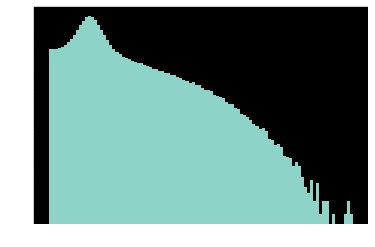

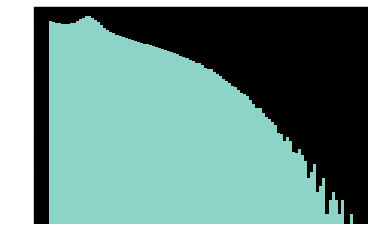

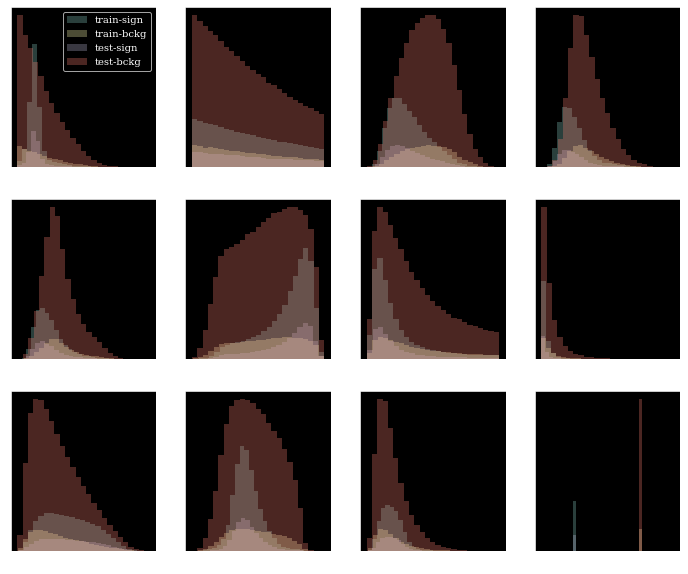

In [3]:
#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')
test = files["test"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]
test_labels=test[::,-1]

data = np.concatenate([train,val,test],axis=0)
maxdata = data.max(axis=0)
mindata = data.min(axis=0)
data = (data-mindata)/(maxdata-mindata)
data[::,0] = 2*(data[::,0]-data[:,0].min())/(data[:,0].max()-data[:,0].min())-1

train = data[:train.shape[0]]
val = data[train.shape[0]:val.shape[0]+train.shape[0]]
test = data[val.shape[0]+train.shape[0]:]




plt.hist(train[::,0],bins=100,log=True)
plt.show()
plt.hist(val[::,0],bins=100,log=True)
plt.show()

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
X = torch.from_numpy(test[:,1:11]).float().to(device)


fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
test_mass = files["test"].astype('float32')[:,0]*250 + 50

In [37]:
model_L = Classifier().to(device)
model_L.train(False)

Classifier(
  (linear): Linear(in_features=10, out_features=64, bias=True)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

Text(0.5, 1.0, '2048 batch size')

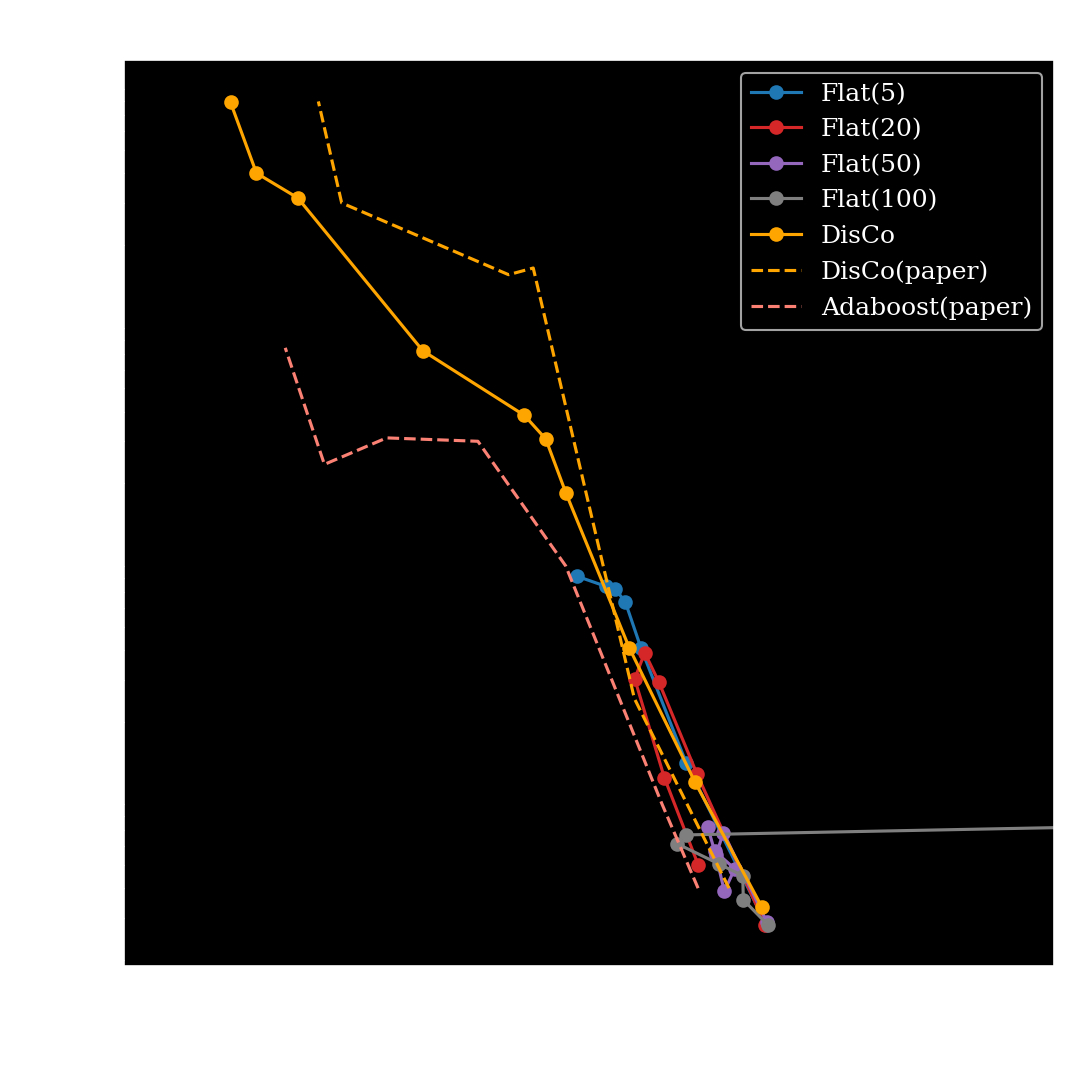

In [53]:
#mod
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
c = ["tab:blue","tab:red","tab:purple","tab:gray"]
for i,b in enumerate([5,20,50,100]):
    jsdr50_ = list()
    files = glob.glob(f"./logs/new/2048/Flat*b{b}).pt")
    for f in files:
        model_L.load_state_dict(torch.load(f))
        out=metric_calc(model=model_L,X=X,y=test_labels,x_biased=test_mass)
        jsdr50_.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split('b')[0] for f in files],dtype=float))
    jsd,r50 = zip(*np.array(jsdr50_)[sort])
    plt.errorbar(r50[:-3],jsd[:-3],fmt='-o',label=f'Flat({b})',c=c[i])
jsdr50 = list()
files = glob.glob("./logs/new/2048/DisCo*.pt")
for f in files:
    model_L.load_state_dict(torch.load(f))
    out=metric_calc(model=model_L,X=X,y=test_labels,x_biased=test_mass)
    jsdr50.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split(')')[0] for f in files],dtype=int))
jsd,r50 = zip(*np.array(jsdr50)[sort])
plt.errorbar(r50,jsd,fmt='-o',label='DisCo',c='orange')

JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    

plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("2048 batch size",fontsize=20)

In [42]:
jsdr50_

[(5.0539434225777695, 21.984924623115575),
 (12.59775103297989, 85555.55555555556),
 (2.8109724858727785, 27.381672060026318),
 (6.691806100177756, 18.911484428725807),
 (14.42191416395535, 70000.0),
 (9.334125354415278, 51333.333333333336),
 (3.5766219660061807, 24.536358422025366),
 (4.51159288649369, 24.467747060692723),
 (7.516852600606928, 77000.0),
 (6.1526090723829885, 18.17538062079547)]

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


Text(0.5, 1.0, '2048 batch size')

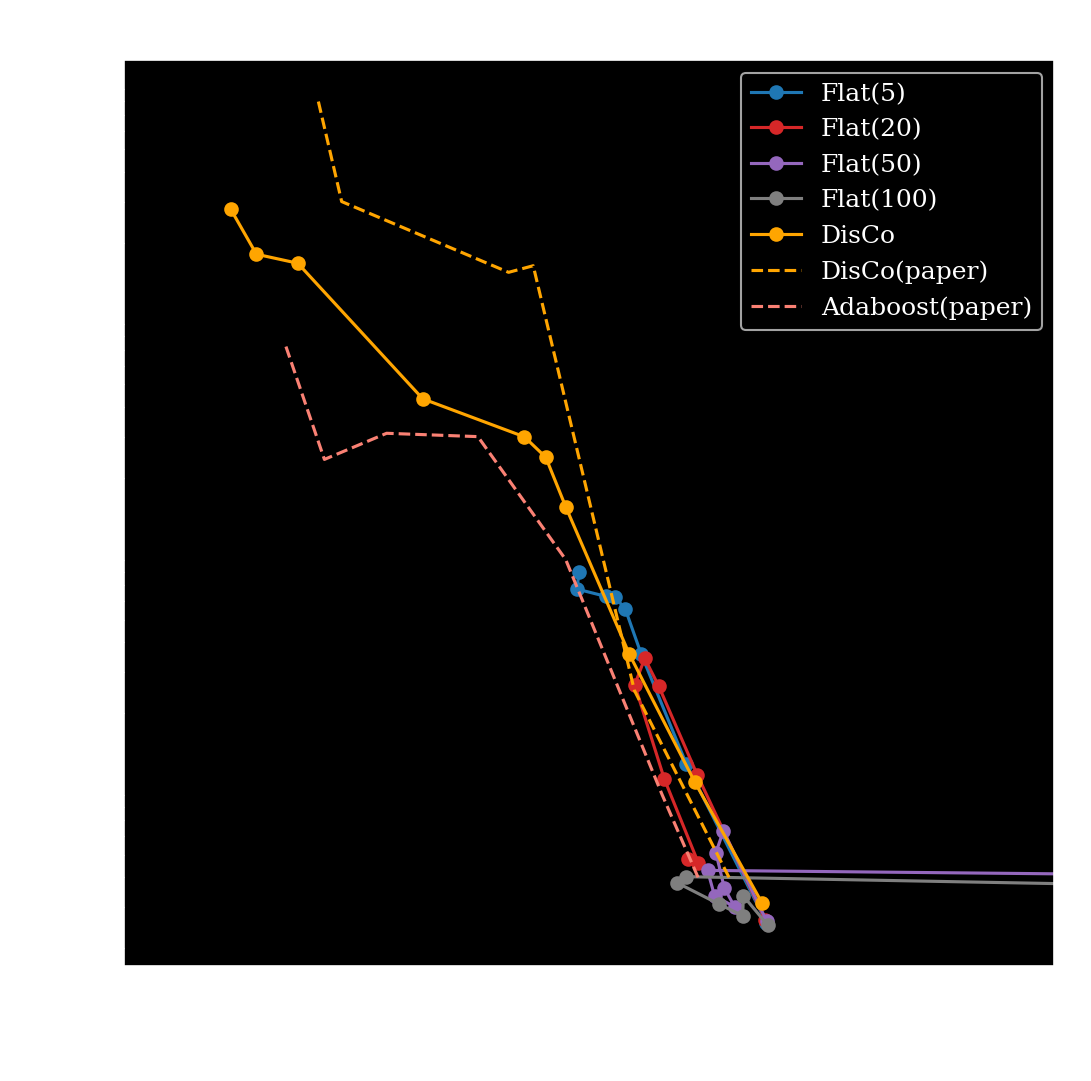

In [50]:
#mod
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
c = ["tab:blue","tab:red","tab:purple","tab:gray"]
for i,b in enumerate([5,20,50,100]):
    jsdr50 = list()
    files = glob.glob(f"./logs/new/2048/Flat*b{b}).pt")
    for f in files:
        model_L.load_state_dict(torch.load(f))
        out=metric_calc(model=model_L,X=X,y=test_labels,x_biased=test_mass,metric=Metrics2)
        jsdr50.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split('b')[0] for f in files],dtype=float))
    jsd,r50 = zip(*np.array(jsdr50)[sort])
    plt.errorbar(r50[:-2],jsd[:-2],fmt='-o',label=f'Flat({b})',c=c[i])
jsdr50_2 = list()
files = glob.glob("./logs/new/2048/DisCo*.pt")
for f in files:
    model_L.load_state_dict(torch.load(f))
    out=metric_calc(model=model_L,X=X,y=test_labels,x_biased=test_mass,metric=Metrics2)
    jsdr50_2.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split(')')[0] for f in files],dtype=int))
jsd_2,r50_2 = zip(*np.array(jsdr50_2)[sort])
plt.errorbar(r50_2,jsd_2,fmt='-o',label='DisCo',c='orange')

JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    

plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("2048 batch size",fontsize=20)

Text(0.5, 1.0, '2048 batch size')

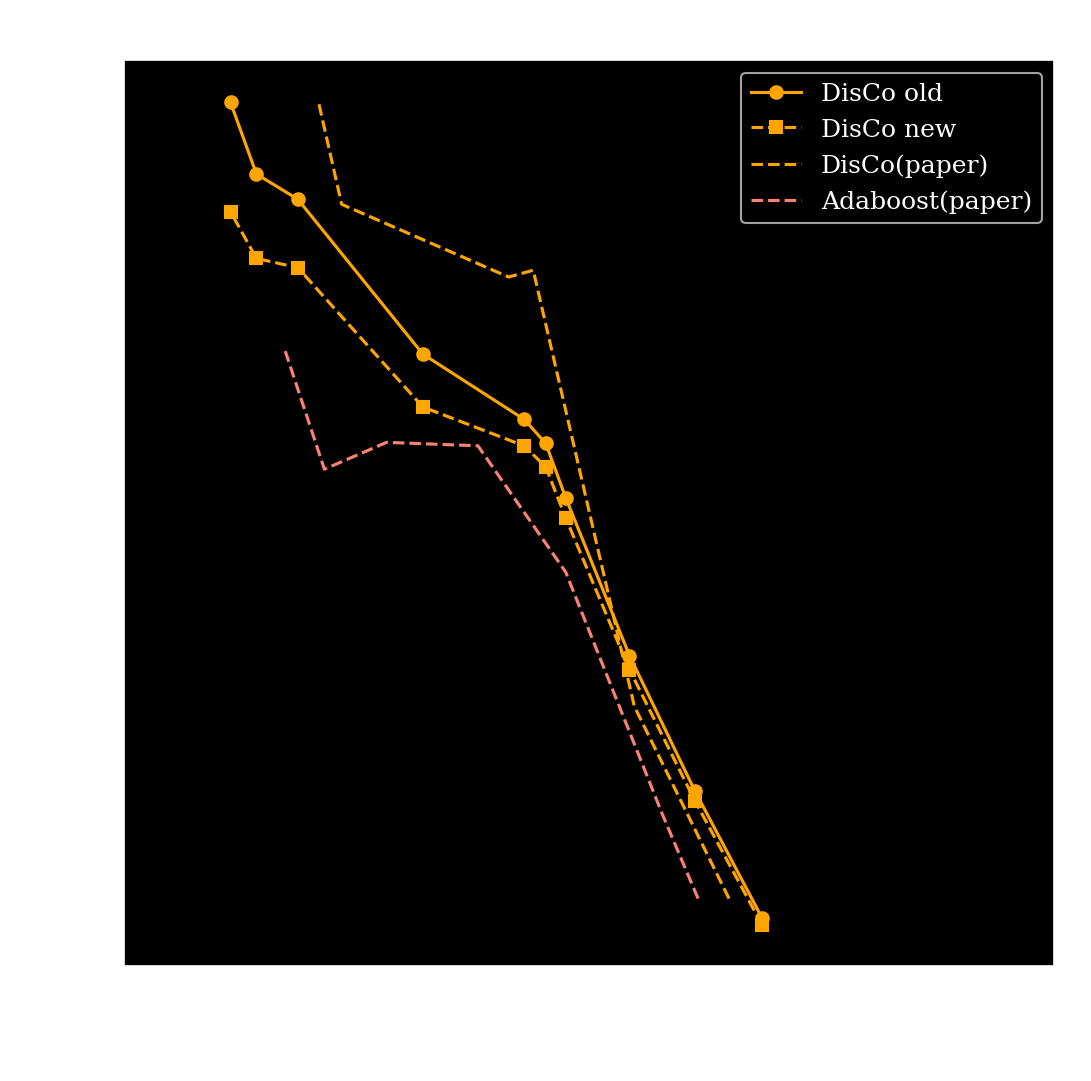

In [67]:
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(r50,jsd,fmt='-o',label='DisCo old',c='orange')
plt.errorbar(r50_2,jsd_2,fmt='-s',label='DisCo new',c='orange',ls="--")

JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    

plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("2048 batch size",fontsize=20)

# Retesting

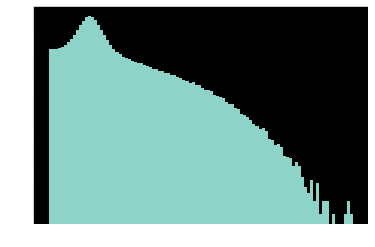

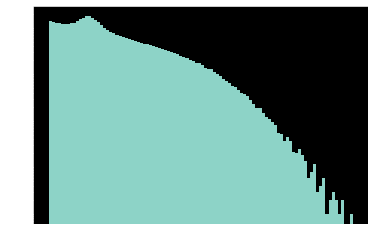

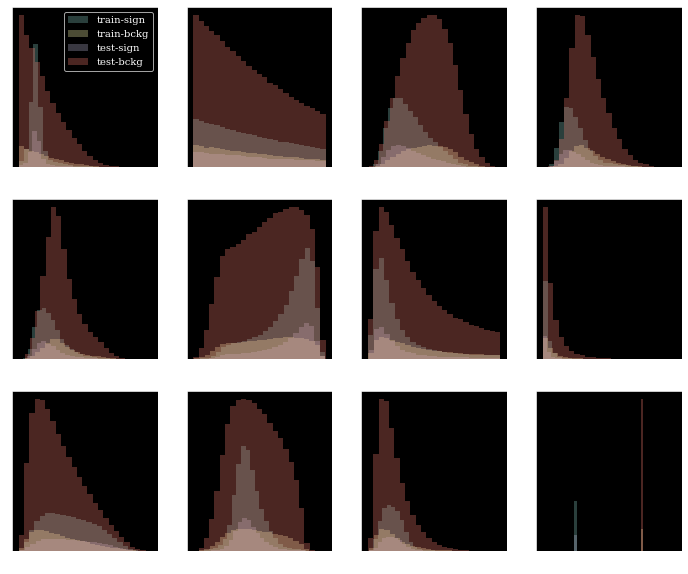

In [59]:
#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')
test = files["test"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]
test_labels=test[::,-1]

# data = np.concatenate([train,val,test],axis=0)
# maxdata = data.max(axis=0)
# mindata = data.min(axis=0)
# data = (data-mindata)/(maxdata-mindata)
# data[::,0] = 2*(data[::,0]-data[:,0].min())/(data[:,0].max()-data[:,0].min())-1

# train = data[:train.shape[0]]
# val = data[train.shape[0]:val.shape[0]+train.shape[0]]
# test = data[val.shape[0]+train.shape[0]:]




plt.hist(train[::,0],bins=100,log=True)
plt.show()
plt.hist(val[::,0],bins=100,log=True)
plt.show()

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
X = torch.from_numpy(test[:,1:11]).float().to(device)


fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
test_mass = files["test"].astype('float32')[:,0]*250 + 50

In [65]:
params = {'epochs'     : 200,
          'interval'   : 200,
          'batch_size' : 2048,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

strength 1
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (786.6s)
 Train: loss:0.2271, acc:77% || Val: loss: 0.0597, acc:78%, R50: 19.3719, 1/JSD: 5.1255


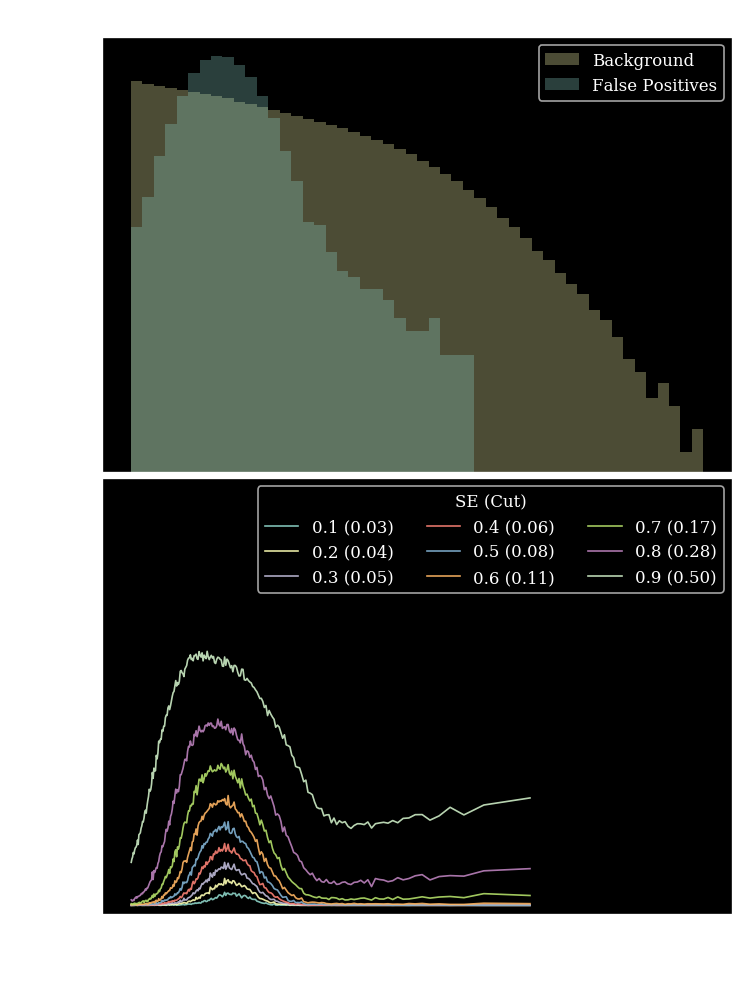

strength 5
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (851.5s)
 Train: loss:0.2829, acc:71% || Val: loss: 0.0702, acc:74%, R50: 10.6055, 1/JSD: 111.8316


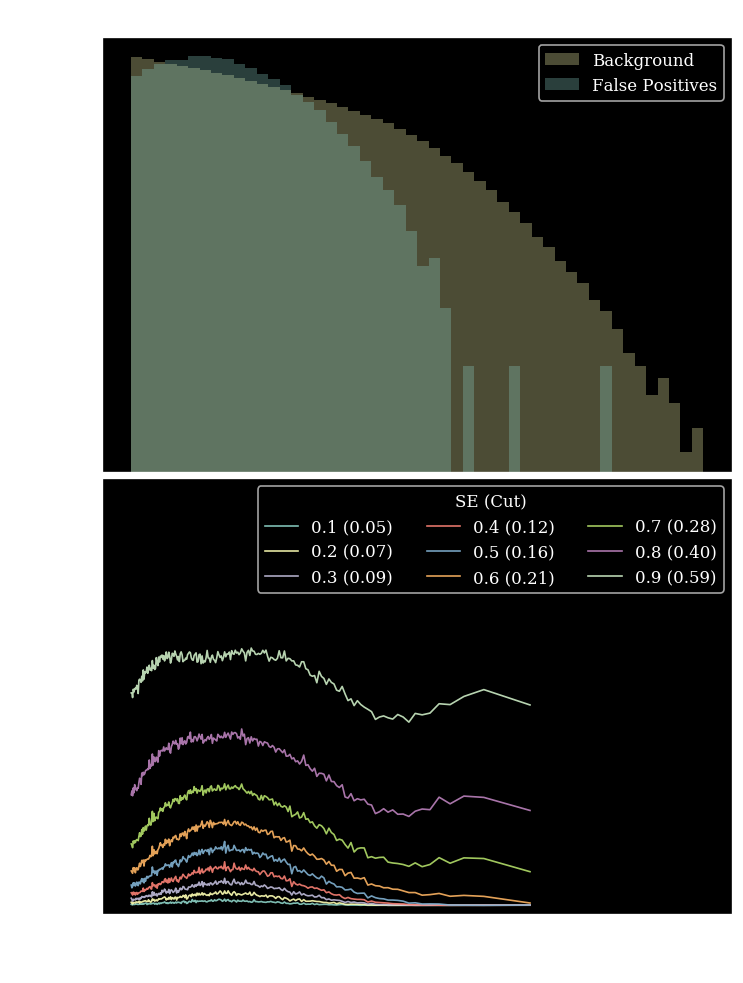

strength 10
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (790.2s)
 Train: loss:0.3514, acc:68% || Val: loss: 0.0803, acc:70%, R50: 7.4558, 1/JSD: 1390.0370


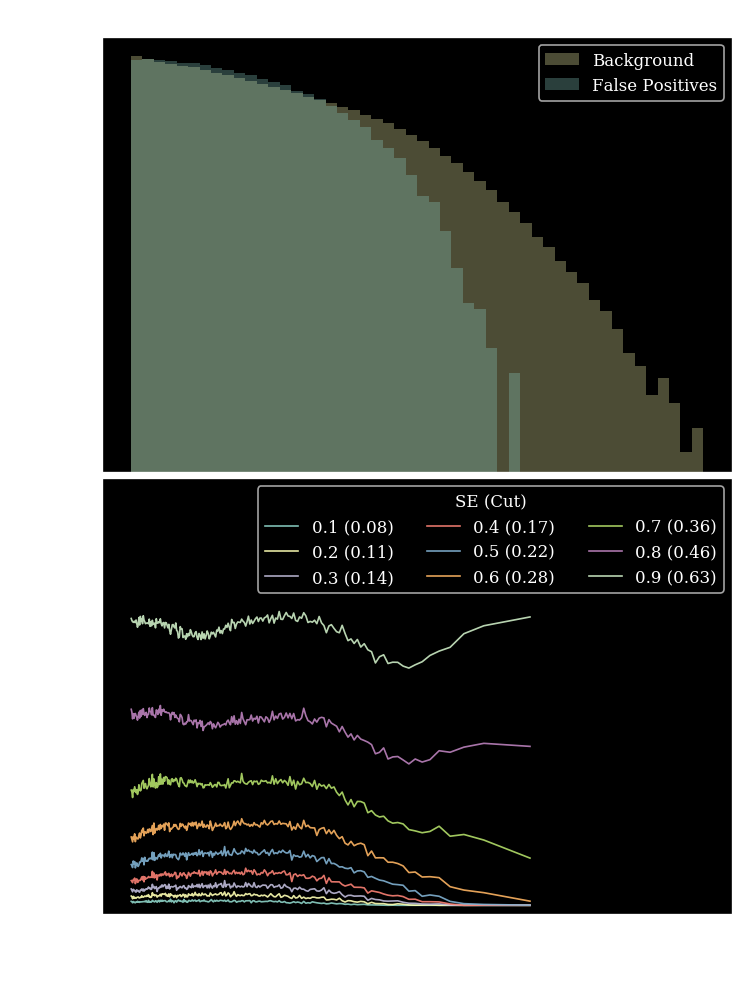

strength 30
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (819.9s)
 Train: loss:0.3870, acc:52% || Val: loss: 0.0973, acc:50%, R50: 2.2376, 1/JSD: 10639.1180


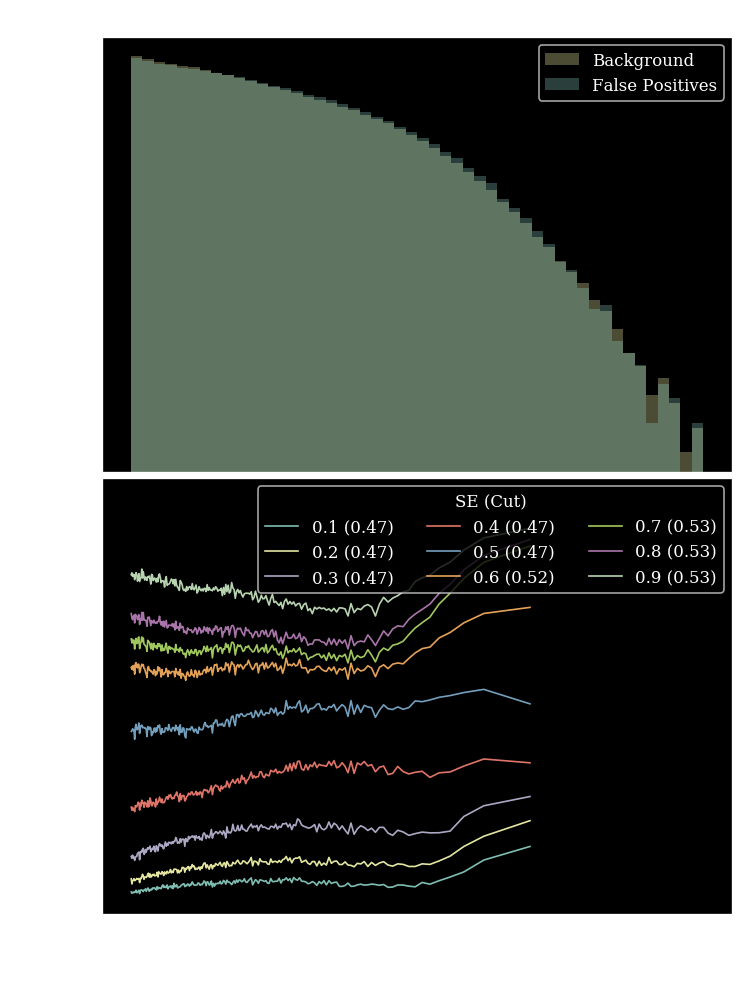

strength 50
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (787.9s)
 Train: loss:0.4146, acc:52% || Val: loss: 0.0975, acc:49%, R50: 2.1847, 1/JSD: 11737.0862


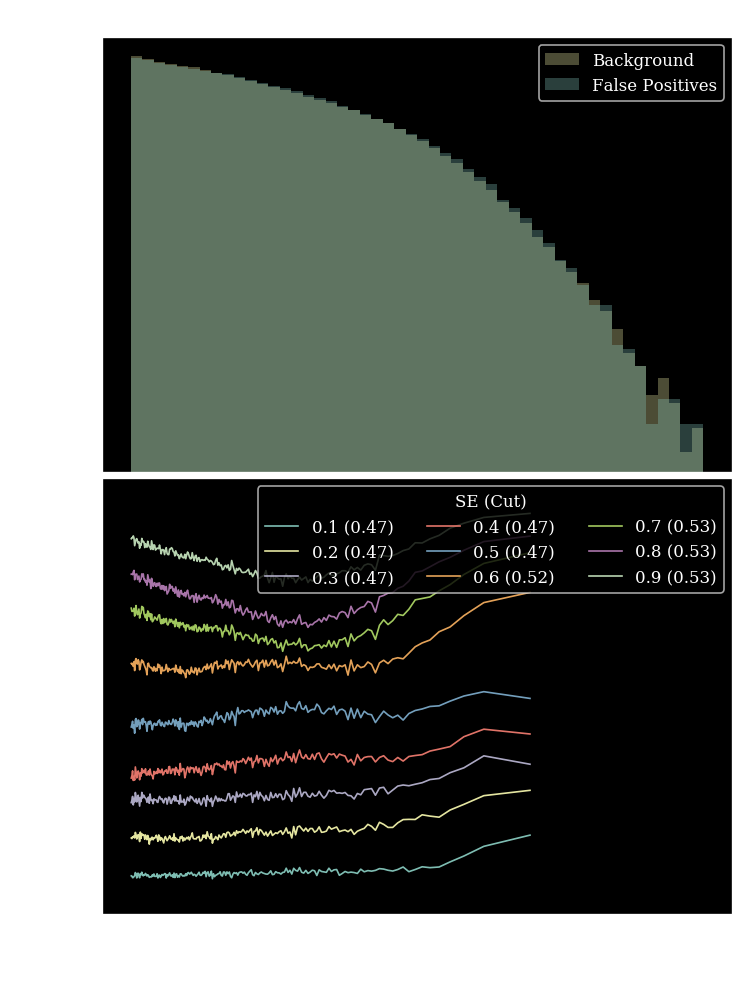

strength 100
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (788.7s)
 Train: loss:0.4775, acc:52% || Val: loss: 0.0976, acc:49%, R50: 2.1155, 1/JSD: 12065.5957


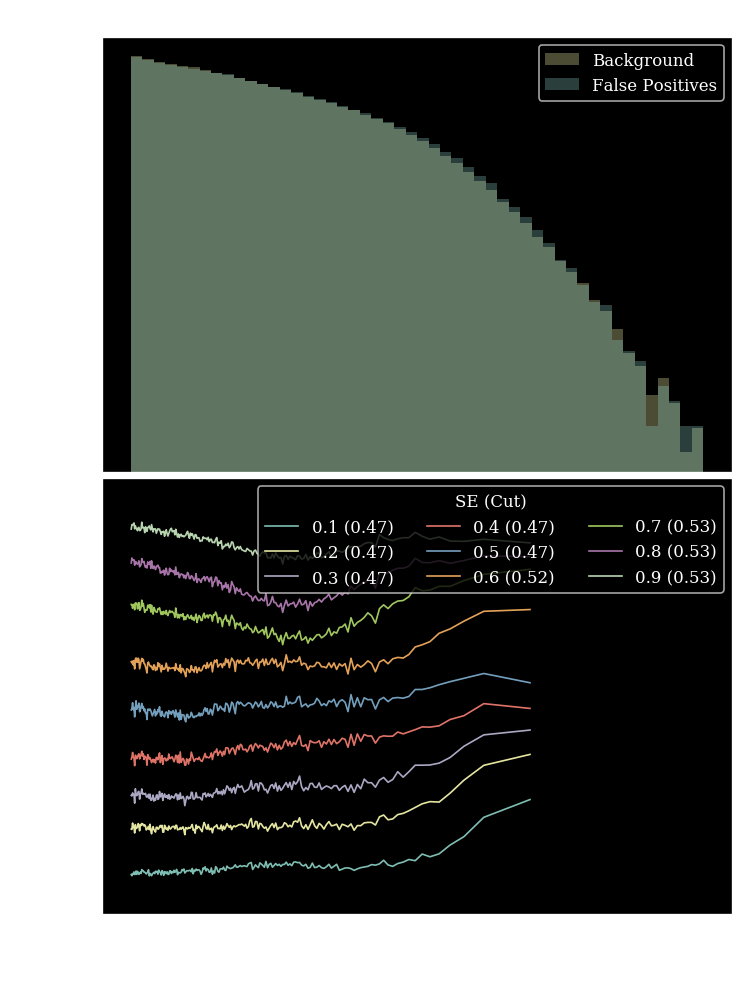

strength 150
Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (787.6s)
 Train: loss:0.5450, acc:52% || Val: loss: 0.0976, acc:49%, R50: 2.1443, 1/JSD: 9659.1664


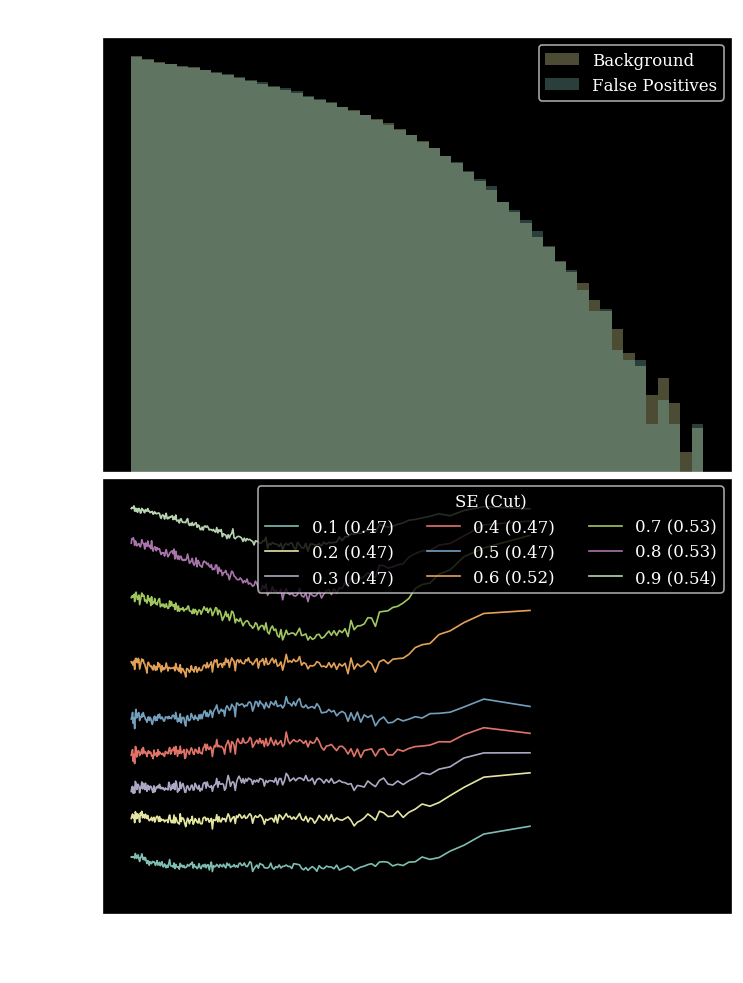

strength 200
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (785.1s)
 Train: loss:0.6047, acc:52% || Val: loss: 0.0977, acc:49%, R50: 2.1078, 1/JSD: 13171.2829


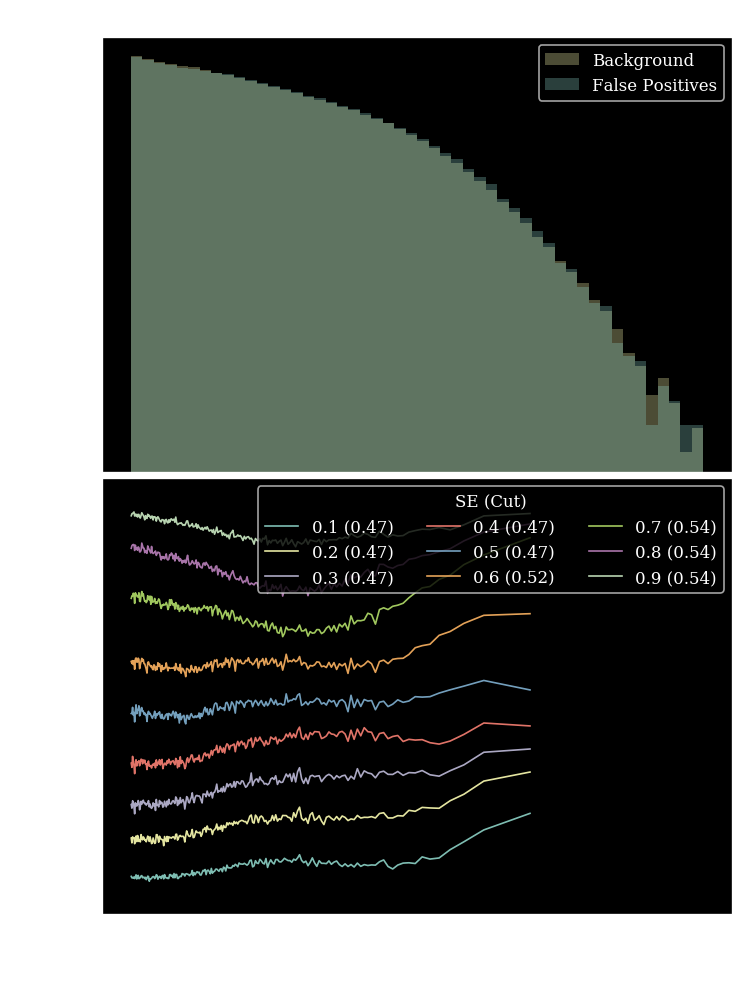

strength 1000
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.1336, acc:80%, R50: 1.7953, 1/JSD: 11.9448
Epoch:0200/0200  (819.2s)
 Train: loss:1.7076, acc:52% || Val: loss: 0.0977, acc:49%, R50: 2.1199, 1/JSD: 12930.1288


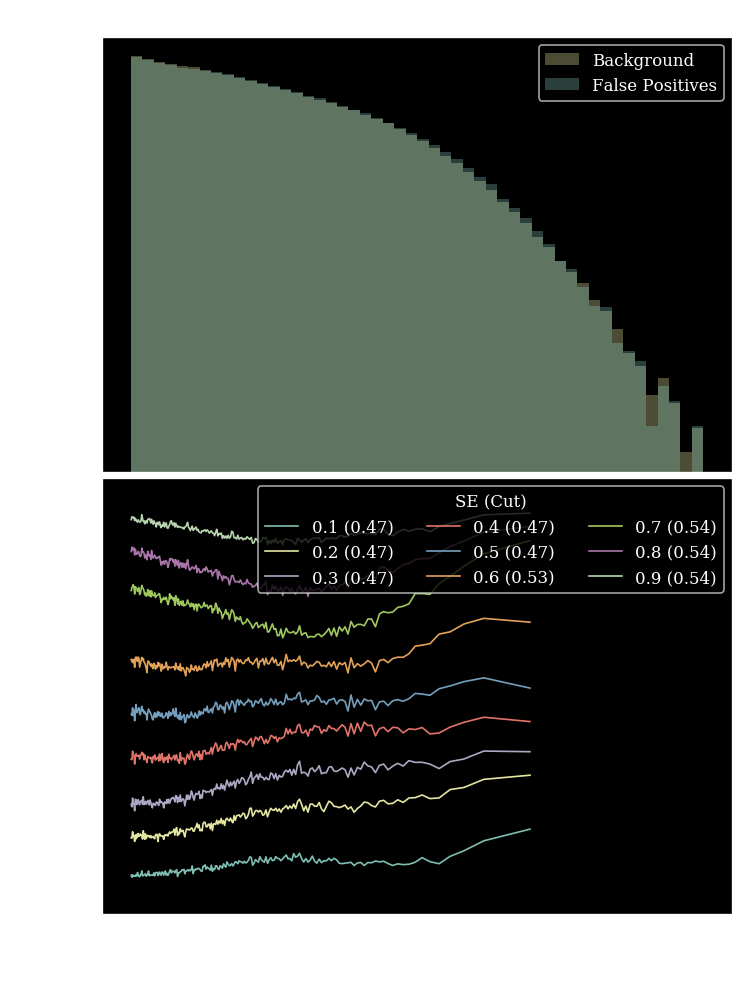

In [72]:
jsdR50Disco = []
for i,frac in enumerate([1,5,10,20,30,50,100,150,200,1000]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(42)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    log=Logger(f"./logs/new/2048_2/DisCo(f{frac}).txt")
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              metrics=[metrics_train_L,metrics_val_L])
    torch.save(model_L.state_dict(),f"./logs/new/2048_2/DisCo(f{frac}).pt")
    out=plot_stuff(model=model_L,name=f"DisCo DNN str:{frac}",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,
                       f=f"./logs/new/2048_2/DisCo(f{frac}).png")

    jsdR50Disco.append(out)